In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
train_df = pd.read_csv('training_set_pixel_size_and_HC.csv')
print("traing file")
print(train_df.info())
print("frist column")
print(train_df.head())

test_df = pd.read_csv('test_set_pixel_size.csv')
print("\n" + "="*50)
print("test file")
print(test_df.info())
print("frist column")
print(test_df.head())

traing file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 999 non-null    object 
 1   pixel size(mm)           999 non-null    float64
 2   head circumference (mm)  999 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.5+ KB
None
frist column
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81

test file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fil

In [21]:
base_path = '/content/drive/MyDrive/pratical 2'
train_img_dir = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/training_set')
csv_path = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/training_set_pixel_size_and_HC.csv')
train_csv = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/training_set_pixel_size_and_HC.csv')
test_csv = os.path.join(base_path, 'test_set_pixel_size.csv')
test_img_dir = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/test_set')

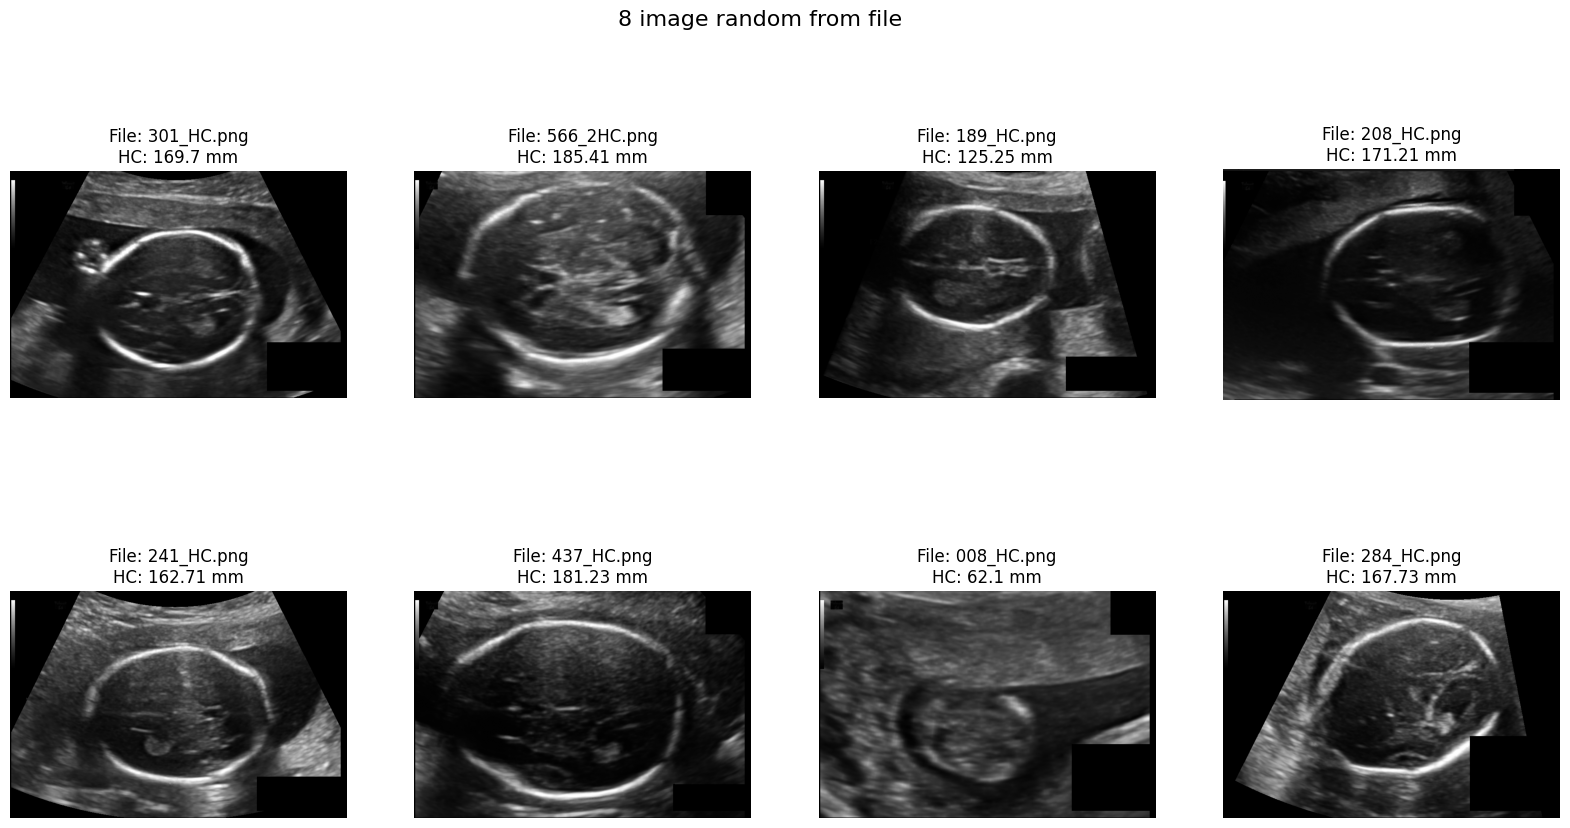

In [17]:
def show_training_samples(csv_path, img_dir, num_samples=8):
    df = pd.read_csv(csv_path)
    samples = df.sample(num_samples)

    plt.figure(figsize=(20, 10))
    plt.suptitle("8 image random from file", fontsize=16)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, row['filename'])
        img = Image.open(img_path)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"File: {row['filename']}\nHC: {row['head circumference (mm)']} mm")
        plt.axis('off')
    plt.show()

#run
show_training_samples(train_csv, train_img_dir)

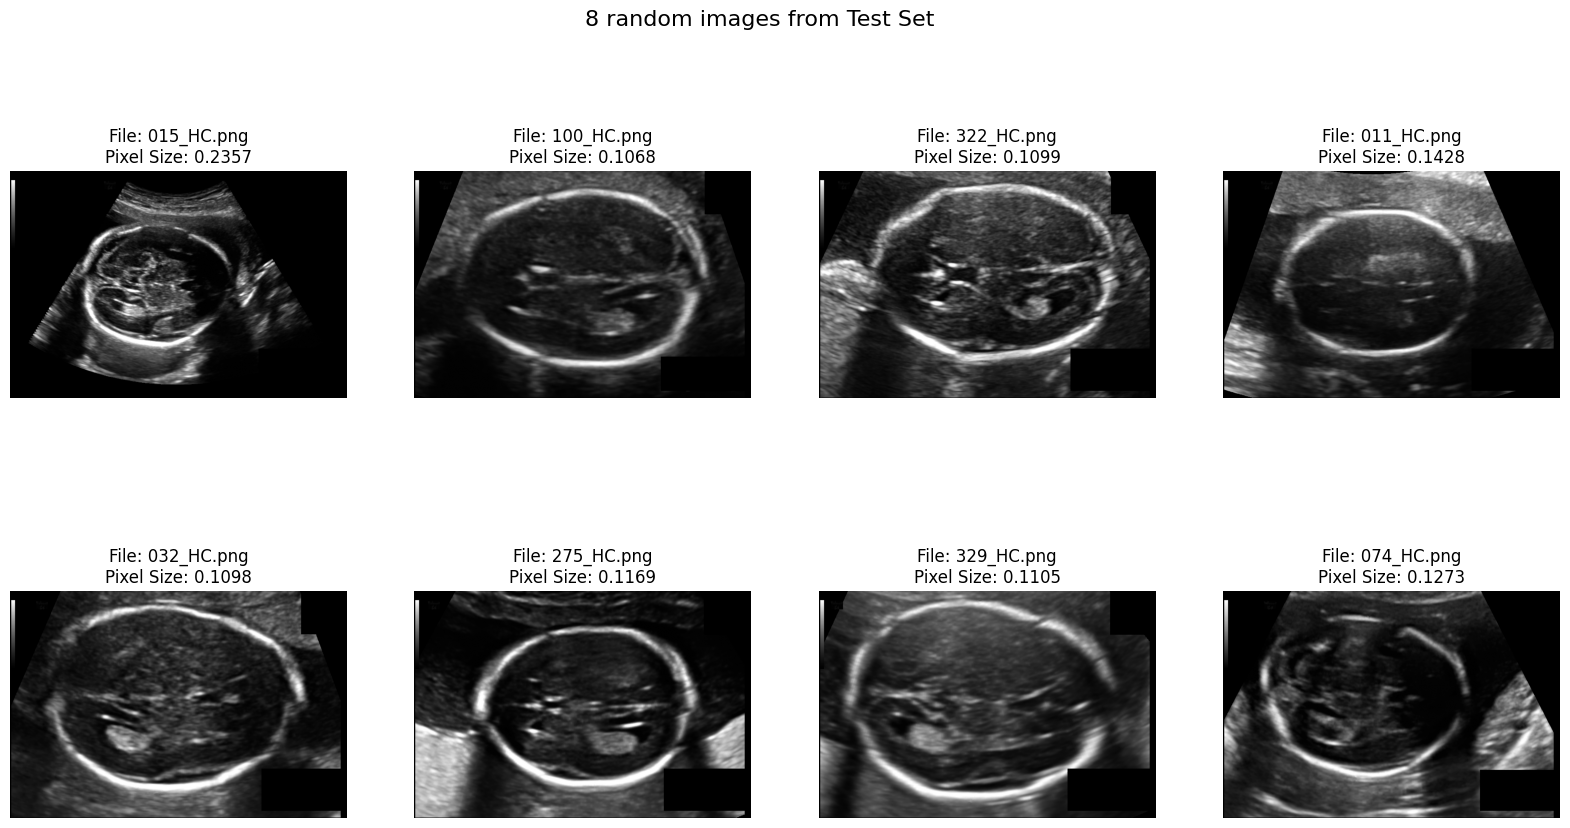

In [47]:
def show_test_samples(csv_path, img_dir, num_samples=8):
    df = pd.read_csv(csv_path)
    samples = df.sample(num_samples)

    plt.figure(figsize=(20, 10))
    plt.suptitle("8 random images from Test Set", fontsize=16)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, row['filename'])
        img = Image.open(img_path)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"File: {row['filename']}\nPixel Size: {row['pixel size(mm)']:.4f}")
        plt.axis('off')
    plt.show()

# run again :D
show_test_samples(test_csv,test_img_dir)

In [4]:
#Data pipeline

In [31]:
class HC18Dataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
      return len(self.df)
    def __getitem__(self, idx):
      img_name = self.df.iloc[idx, 0]
    #i want the circumference value is the label :v
      label = float(self.df.iloc[idx, 2])
      img_path = os.path.join(self.img_dir, img_name)
    #graysclaee
      image = Image.open(img_path).convert('L')

      if self.transform:
          image = self.transform(image)

      return image, torch.tensor([label], dtype=torch.float32)

In [32]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [33]:
full_dataset = HC18Dataset(csv_path, train_img_dir, transform=data_transform)

In [25]:
# 80 for tran and 20% for valid

In [34]:
train_indices, val_indices = train_test_split(
    range(len(full_dataset)), test_size=0.2, random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# --- DATALOADER ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"NUmber of images for training: {len(train_dataset)}")
print(f"Number of images for testing: {len(val_dataset)}")

NUmber of images for training: 799
Number of images for testing: 200


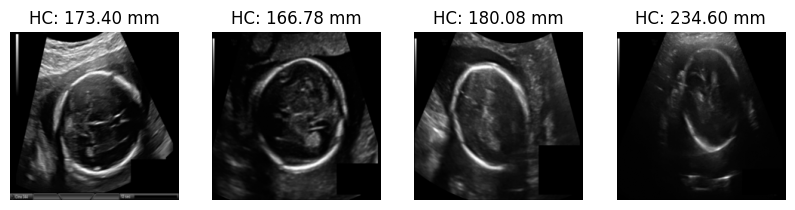

In [35]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"HC: {labels[i].item():.2f} mm")
    plt.axis('off')
plt.show()

In [37]:
#check sample
image, label = full_dataset[0]
print(f"frist sample: {label.item()} mm")

frist sample: 44.29999923706055 mm


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

In [40]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # Conv 1x1: Resize dataset
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Conv 3x3: Feature extracted
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Conv 1x1: go to x4 :D
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        # Downsample operation: Equate matrix size before adding identities.
        if self.downsample is not None:
            identity = self.downsample(x)

        # Residual Connection
        out += identity
        out = self.relu(out)
        return out

In [42]:
class ResNet50_finetune(nn.Module):
    def __init__(self, block, layers):
        super(ResNet50_finetune, self).__init__()
        self.in_planes = 64

        # First layer: Receives ultrasound images (1 channel)
        # Mathematics: Input (Batch, 1, 224, 224) -> Output (Batch, 64, 112, 112)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define 4 Stages of ResNet50
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Ending layer: Pooling and Fully Connected for Regression
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 1)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # Mathematical logic: If the size changes (stride != 1) or the number of channels changes
        # We need a projection to add the identity matrix
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) # Output: [Batch, 1]
        return x

# Initialize the actual ResNet50 model (3, 4, 6, 3 blocks)
model = ResNet50_finetune(Bottleneck, [3, 4, 6, 3])

In [44]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# now we define loss function
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [45]:
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # trainng
        model.train()
        running_train_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            #predict
            outputs = model(images)

            # Cal MAE loss
            loss = criterion(outputs, labels)

            # cal derivative
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        epoch_train_mae = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_mae)

        # test
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad(): #drop derivative
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

        epoch_val_mae = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_mae)

        print(f"Epoch [{epoch+1}/{epochs}] - Train MAE: {epoch_train_mae:.2f} mm | Val MAE: {epoch_val_mae:.2f} mm")

    return train_losses, val_losses
train_mae, val_mae = train_model(model, train_loader, val_loader, epochs=20)

Epoch [1/20] - Train MAE: 126.27 mm | Val MAE: 83.59 mm
Epoch [2/20] - Train MAE: 58.10 mm | Val MAE: 194.48 mm
Epoch [3/20] - Train MAE: 39.73 mm | Val MAE: 66.69 mm
Epoch [4/20] - Train MAE: 38.61 mm | Val MAE: 147.25 mm
Epoch [5/20] - Train MAE: 34.21 mm | Val MAE: 29.79 mm
Epoch [6/20] - Train MAE: 28.15 mm | Val MAE: 49.21 mm
Epoch [7/20] - Train MAE: 28.55 mm | Val MAE: 48.76 mm
Epoch [8/20] - Train MAE: 24.71 mm | Val MAE: 50.21 mm
Epoch [9/20] - Train MAE: 25.20 mm | Val MAE: 30.13 mm
Epoch [10/20] - Train MAE: 24.04 mm | Val MAE: 36.17 mm
Epoch [11/20] - Train MAE: 22.55 mm | Val MAE: 40.24 mm
Epoch [12/20] - Train MAE: 22.31 mm | Val MAE: 90.07 mm
Epoch [13/20] - Train MAE: 21.27 mm | Val MAE: 77.18 mm
Epoch [14/20] - Train MAE: 20.31 mm | Val MAE: 37.02 mm
Epoch [15/20] - Train MAE: 21.44 mm | Val MAE: 30.43 mm
Epoch [16/20] - Train MAE: 20.38 mm | Val MAE: 29.06 mm
Epoch [17/20] - Train MAE: 20.68 mm | Val MAE: 61.73 mm
Epoch [18/20] - Train MAE: 19.63 mm | Val MAE: 24.58 m

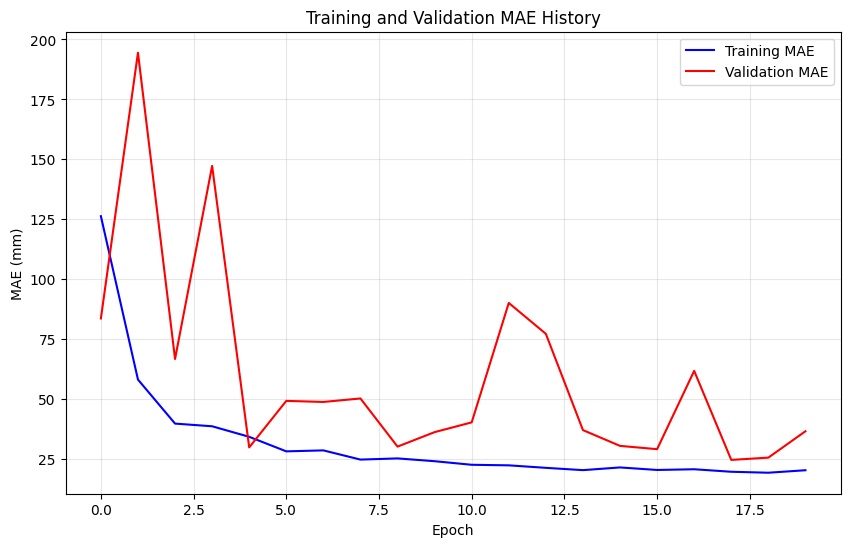

In [53]:
import matplotlib.pyplot as plt

def plot_mae_history(train_mae, val_mae):
    plt.figure(figsize=(10, 6))
    plt.plot(train_mae, color='blue', label='Training MAE')
    plt.plot(val_mae, color='red', label='Validation MAE')

    plt.xlabel('Epoch')
    plt.ylabel('MAE (mm)')
    plt.title('Training and Validation MAE History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
plot_mae_history(train_mae, val_mae)

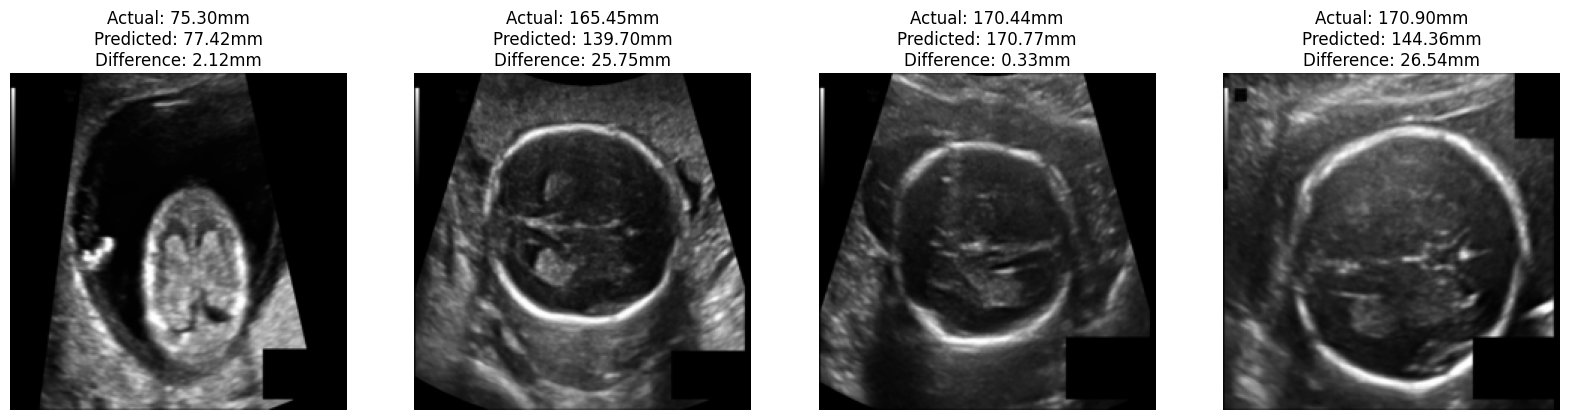

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_samples=4):
    model.eval()
    plt.figure(figsize=(20, 10))

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            output = model(image.unsqueeze(0).to(device))
            pred = output.item()
            actual = label.item()

            plt.subplot(1, num_samples, i + 1)
            img_display = image.squeeze().cpu().numpy() * 0.5 + 0.5
            plt.imshow(img_display, cmap='gray')
            plt.title(f"Actual: {actual:.2f}mm\nPredicted: {pred:.2f}mm\nDifference: {abs(actual-pred):.2f}mm")
            plt.axis('off')
    plt.show()

visualize_predictions(model, val_dataset)

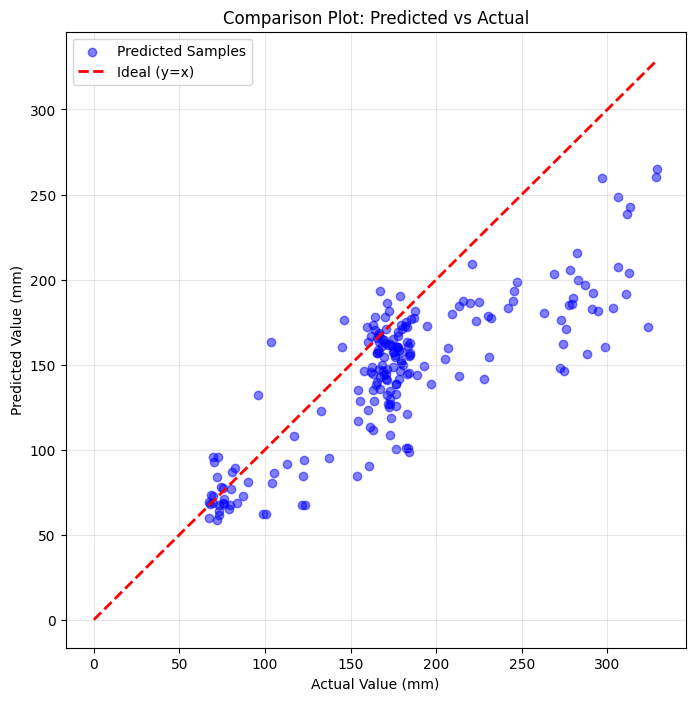

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            out = model(imgs.to(device))
            preds.extend(out.cpu().numpy().flatten())
            targets.extend(lbls.numpy().flatten())

    plt.figure(figsize=(8, 8))
    plt.scatter(targets, preds, color='blue', alpha=0.5, label='Predicted Samples')

    limit = max(max(preds), max(targets))
    plt.plot([0, limit], [0, limit], color='red', linestyle='--', linewidth=2, label='Ideal (y=x)')

    plt.xlabel('Actual Value (mm)')
    plt.ylabel('Predicted Value (mm)')
    plt.title('Comparison Plot: Predicted vs Actual')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_scatter(model, val_loader)

Image 1: 010_HC.png -> Prediction: 165.13 mm
Image 2: 036_HC.png -> Prediction: 201.96 mm
Image 3: 267_HC.png -> Prediction: 92.87 mm
Image 4: 136_HC.png -> Prediction: 136.91 mm


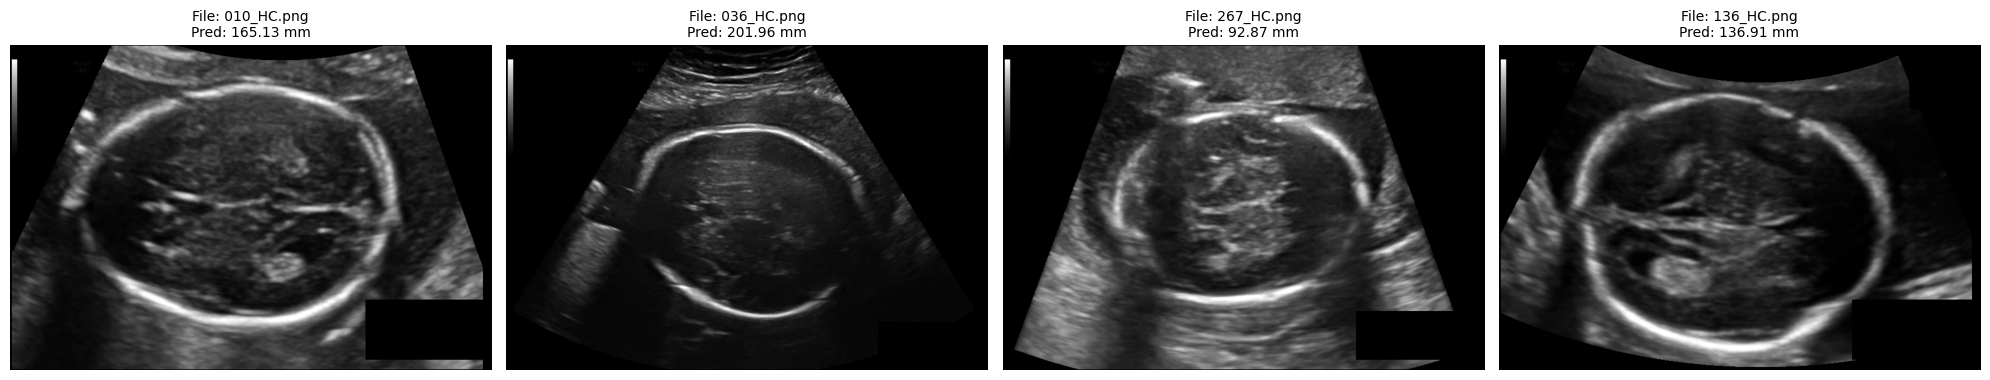

In [51]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def test_multiple_images(model, img_paths, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    model.eval()
    plt.figure(figsize=(20, 5))

    for i, img_path in enumerate(img_paths):
        if not os.path.exists(img_path):
            print(f"Error: File not found {img_path}")
            continue
        image = Image.open(img_path).convert('L')
        image_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model(image_tensor)
        plt.subplot(1, 4, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"File: {os.path.basename(img_path)}\nPred: {prediction.item():.2f} mm", fontsize=10)
        plt.axis('off')

        print(f"Image {i+1}: {os.path.basename(img_path)} -> Prediction: {prediction.item():.2f} mm")

    plt.tight_layout()
    plt.show()

base_test_path = "/content/drive/MyDrive/pratical 2/test_set"
list_test_images = [
    os.path.join(base_test_path, "010_HC.png"),
    os.path.join(base_test_path, "036_HC.png"),
    os.path.join(base_test_path, "267_HC.png"),
    os.path.join(base_test_path, "136_HC.png")
]

test_multiple_images(model, list_test_images, device)